# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---

# Semana 2: _Feature Importance_, Cesgo/Varianza

In [ ]:
# Celdas preparatorias
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

#print(sklearn.__version__)

## Datos sintéticos con `make_classification`

Vamos a generar un conjunto de datos sintético para classificación usando `make_classification` de `datasets`. Con eso podemos elejir el número de elementos, número de características (incluso cuantas son relevantes), número de clases y varias otras propiedades. Miremos algunos ejemplos


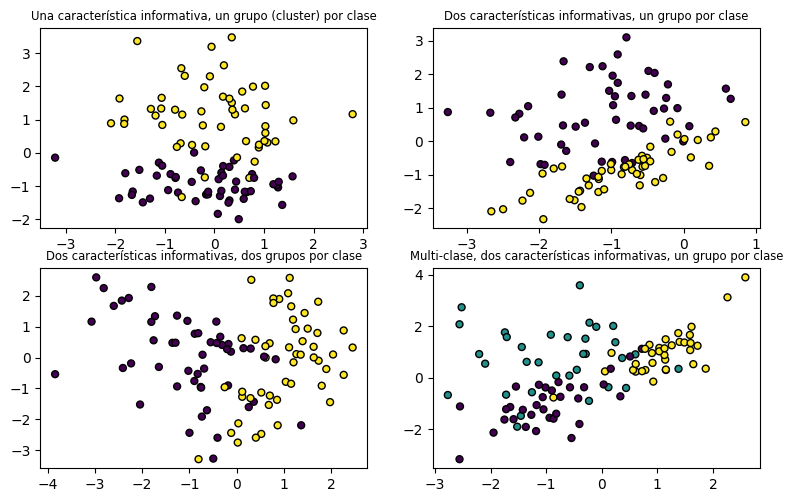

In [ ]:
from sklearn.datasets import make_classification

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("Una característica informativa, un grupo (cluster) por clase", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.subplot(322)
plt.title("Dos características informativas, un grupo por clase", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.subplot(323)
plt.title("Dos características informativas, dos grupos por clase", fontsize="small")
X2, Y2 = make_classification(n_features=2, n_redundant=0, n_informative=2)
plt.scatter(X2[:, 0], X2[:, 1], marker="o", c=Y2, s=25, edgecolor="k")

plt.subplot(324)
plt.title("Multi-clase, dos características informativas, un grupo por clase", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

plt.show()

Ahora vamos a generar nuestro conjunto de datos para probar algunos conceptos.

In [ ]:
from sklearn.model_selection import train_test_split

# Genera un conjunto de datos para clasificación binária

X, y = make_classification(
    n_samples=1000, # 500
    n_features=15, # 25
    n_informative=3, # 15
    n_redundant=0, # 3,
    n_repeated=0,
    n_classes=2,
    random_state=0, # lo fijamos al fin!
    shuffle=False,
#    n_clusters_per_class=1,
)
# Usaremos estos datos en aplicaciones de Random Forest para clasificación
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# forma del conjunto de datos
print(X.shape, y.shape)

feature_names = [f"característica {i}" for i in range(X.shape[1])] #nombres de las características

(1000, 15) (1000,)


## Repaso: clasificador de Bosque Aleatorio (_Random Forest_)

El `RandomForestClassifier` se entrena utilizando agregación bootstrap, donde cada nuevo árbol se ajusta a partir de una muestra bootstrap de los datos de entrenamiento.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# retengamos este clasificador, porque lo volveremos a usar!
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Errores OOB (Out-Of-Bag) para Bosques Aleatorios (Random Forests)

El error OOB es el error promedio para cada muestra de _bootstrap_ obtenido usando los árboles entrenados en su respectiva muestra pero usando predicciones sobre los datos originales que no están en esa muestra.

Esto permite que el `RandomForestClassifier` se ajuste y valide mientras se entrena.

El siguiente ejemplo demuestra cómo se puede medir el error OOB al agregar cada nuevo árbol durante el entrenamiento. El gráfico resultante permite obtener un valor adecuado de `n_estimators` en el cual el error se estabiliza.

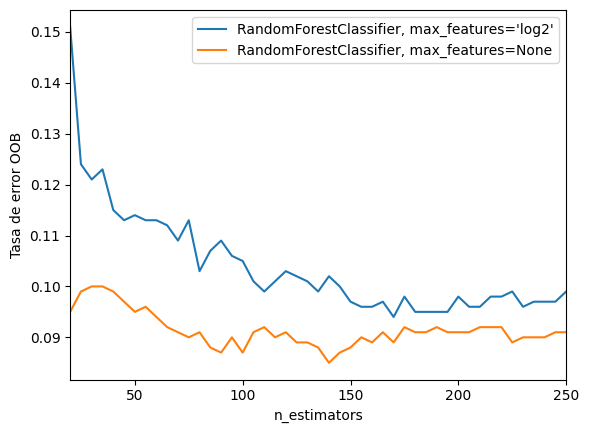

In [ ]:
from collections import OrderedDict
# NOTA: Establecer el parámetro de construcción `warm_start` en `True` deshabilita
# el soporte para ensembles paralelizados, pero es necesario para rastrear
# la trayectoria del error OOB durante el entrenamiento.

RANDOM_STATE = 123 # aqui fijamos el random_state

ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Asocia un nombre de clasificador a una lista de pares (<n_estimators>, <tasa de error>).
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Rango de valores de `n_estimators` para explorar.
min_estimators = 20
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Graba el error OOB para cada `n_estimators=i1
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Genera el gráfico "Tasa de error OOB" vs. "n_estimators".
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Tasa de error OOB")
plt.legend(loc="upper right")
plt.show()

# Importancia de las características / _Feature Importance_

La importancia de las características se refiere a las técnicas que asignan una puntuación (_score_) a las características de entrada en función de cuán útiles son para predecir una variable objetivo.

Los _scores_ de importancia de características desempeñan un papel importante en un proyecto de modelado predictivo, incluyendo proporcionar información sobre los datos, comprender el modelo y servir como base para la reducción de dimensionalidad y la selección de características, lo que puede mejorar la eficiencia y efectividad de un modelo predictivo en el problema.

Existen muchos tipos y fuentes de _scores_ de importancia de características. Entre los más comunes están _scores_ de coeficientes calculados como parte de modelos lineales, árboles de decisión y de correlación estadística.


## Importancia de Características en Árboles de Decisión

Los algoritmos de árboles de decisión, como los árboles de clasificación y regresión (CART), ofrecen puntuaciones de importancia basadas en la reducción en el criterio utilizado para seleccionar puntos de división, como Gini o entropía.

Este mismo enfoque se puede utilizar para conjuntos de árboles de decisión, como el bosque aleatorio (_random forest_) y los algoritmos de aumento de gradiente estocástico (stochastic gradient boosting), que estudiaremos más adelante.

Veamos algunos ejemplos

### Importancia de Características en CART

Podemos utilizar el algoritmo CART para la importancia de características implementada en `scikit-learn` a través de las clases `DecisionTreeRegressor` y `DecisionTreeClassifier`.

Después de ser ajustado, el modelo proporciona una propiedad
```
feature_importances_
```
a la que se puede acceder para recuperar las puntuaciones de importancia relativa para cada característica de entrada.

Miremos un ejemplo de esto para regresión y clasificación.

### Recordemos el ejemplo del conjunto de datos Iris

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

iris=datasets.load_iris()

# Nos quedamos con los dos primeros features
datos = iris.data[:, 2:]
etiquetas = iris.target

# Sacamos los nombres
# labelx, labely = iris.feature_names[2:]
labelx, labely = ['Largo del pétalo (cm)', 'Ancho del pétalo (cm)']

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(datos, etiquetas)


DecisionTreeClassifier(max_depth=2, random_state=42)

#### La función para graficar las fronteras de decisión

Para graficar las regiones de decisión, generamos una cuadrícula de puntos y obtenemos la predicción del modelo sobre ella.

Luego utilizamos el método `contourf` para pintar la región. Todo esto se implementa en esta función de A. Gèron:

In [ ]:
# Función adaptada de A. Gèron
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, t, axes=[0, 7.5, 0, 3], is_iris=True,
                           legend=False, plot_training=True, ngridpoints=200,
                           alpha=1.0, ax=None):

    # Prepara los arreglos para colorear
    x1s = np.linspace(axes[0], axes[1], ngridpoints)
    x2s = np.linspace(axes[2], axes[3], ngridpoints)

    # los convierte en una grilla
    x1, x2 = np.meshgrid(x1s, x2s)

    # Calcula las predicciones sobre la grilla
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    if ax is None:
        ax = plt.figure().add_subplot(111)

    # Grafica con colores esa grilla
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if not is_iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        sct = ax.scatter(X[:,0], X[:, 1], c=t, edgecolors='k', s=9**2,
                  cmap=plt.cm.rainbow, alpha=alpha)

        # plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        # plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        # plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        # plt.axis(axes)
    if is_iris:
        legend1 = ax.legend(sct.legend_elements()[0], iris.target_names,
                            loc="upper left", title="Clases")
        ax.add_artist(legend1)

        ax.set_xlabel("Largo del pétalo", fontsize=16)
        ax.set_ylabel("Ancho del pétalo", fontsize=16)
    else:
        ax.set_xlabel(r"$x_1$", fontsize=18)
        ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        ax.legend(loc="lower right", fontsize=14)


#### Visualización de los datos y las regiones definidas por el árbol de decisión

<Figure size 1200x800 with 0 Axes>

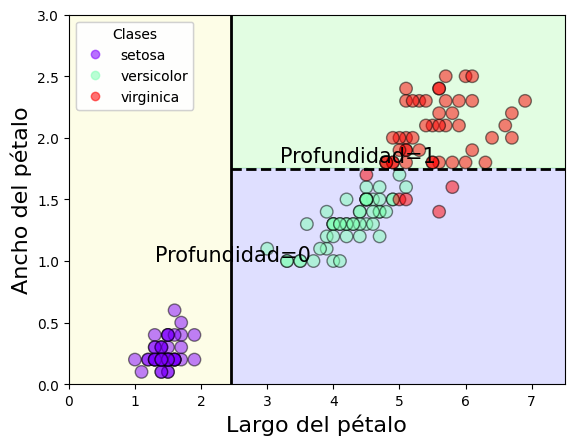

In [ ]:
plt.figure(figsize=(12, 8))
plot_decision_boundary(tree_clf, datos, etiquetas, alpha=0.5)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.30, 1.0, "Profundidad=0", fontsize=15)
plt.text(3.2, 1.80, "Profundidad=1", fontsize=15)

plt.show()

#### Importancias de las características

Comparando las reducciones de impurezas dadas por el mejor corte de cada característica podemos estimar la _importancias de las características_ (*feature importances*), a la que se accede a través del atributo `.feature_importances_`.

In [ ]:
tree_clf.feature_importances_

array([0.56199095, 0.43800905])

<BarContainer object of 2 artists>

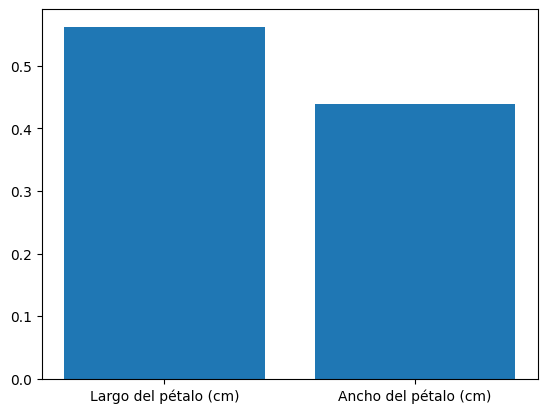

In [ ]:
plt.bar(['Largo del pétalo (cm)', 'Ancho del pétalo (cm)'], tree_clf.feature_importances_)

En este caso, vemos que ambas características paracen tener una importancia similar, con una ligera ventaja para el largo del pétalo.

#### Con más datos, dimensiones y controlando las que importan...

Ahora vamos a ver lo que pasa en un conjunto de datos sintéticos com más dimensiones (características) y donde podemos controlar cuales son importantes.

Feature: 0, Score: 0.02206
Feature: 1, Score: 0.01766
Feature: 2, Score: 0.18977
Feature: 3, Score: 0.31164
Feature: 4, Score: 0.08988
Feature: 5, Score: 0.01145
Feature: 6, Score: 0.17082
Feature: 7, Score: 0.03553
Feature: 8, Score: 0.12300
Feature: 9, Score: 0.02819


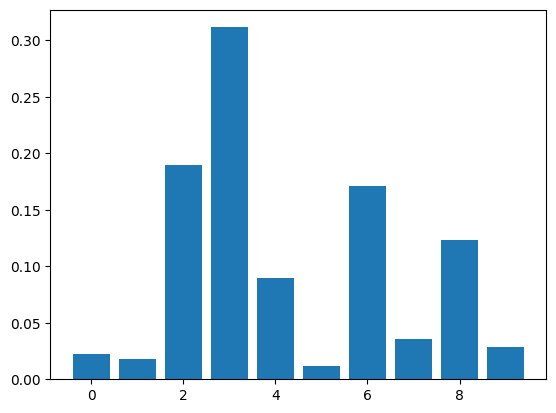

In [ ]:
# Define el conjunto de datos
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# Define el modelo
model = DecisionTreeClassifier()

# Ajusta el modelo
model.fit(X, y)

# graba la importancia
importance = model.feature_importances_

# Sintetiza la importancia de las características
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# Grafica de la importancia de las características
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Los resultados sugieren que 4 o 5 de las 10 características son importantes para la predicción.

Un ejemplo con regresión

Feature: 0, Score: 0.00151
Feature: 1, Score: 0.54698
Feature: 2, Score: 0.00071
Feature: 3, Score: 0.00035
Feature: 4, Score: 0.00030
Feature: 5, Score: 0.00063
Feature: 6, Score: 0.00069
Feature: 7, Score: 0.00113
Feature: 8, Score: 0.00066
Feature: 9, Score: 0.44704


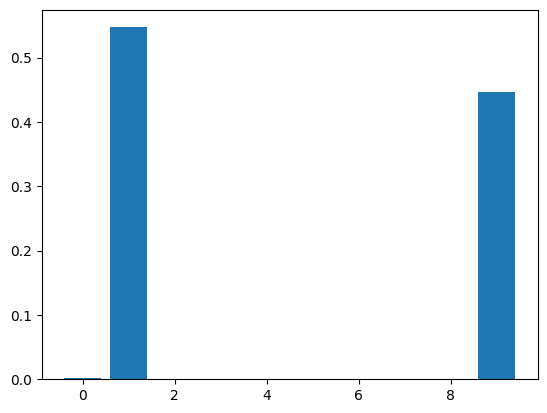

In [ ]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

# Definimos el conjunto de datos
X, y = make_regression(n_samples=1000, n_features=10, n_informative=3, random_state=1)

# Elegimos el modelo
model = DecisionTreeRegressor()

# Ajustamos el modelo
model.fit(X, y)

# Grabamos las importancias
importance = model.feature_importances_

# Resumen de la importancia de las características
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# Gráfica de la importancia de las características
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Random Forest: importancia de las características basada en la disminución promedio en la impureza - _Mean decrease in impurity_ (MDI)

Las importancias de las características se obtienen mediante el atributo ajustado `feature_importances`, y se calculan como la media y la desviación estándar de la acumulación de la disminución de la impureza dentro de cada árbol.

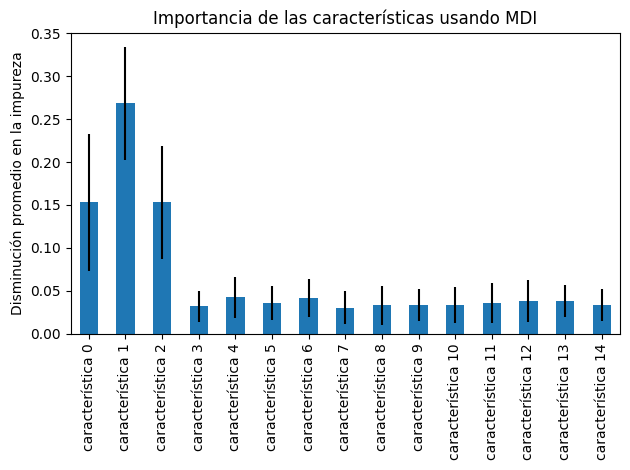

In [ ]:
# Por completitud, generamos nuevamente los datos
# Genera un conjunto de datos para clasificación binária

X, y = make_classification(
    n_samples=1000, # 500
    n_features=15, # 25
    n_informative=3, # 15
    n_redundant=0, # 3,
    n_repeated=0,
    n_classes=2,
    random_state=0, # lo fijamos al fin!
    shuffle=False,
#    n_clusters_per_class=1,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

feature_names = [f"característica {i}" for i in range(X.shape[1])] #nombres de las características

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importancia de las características usando MDI")
ax.set_ylabel("Disminución promedio en la impureza")
fig.tight_layout()



Vemos que las tres primeras características son las mas importantes.

# Importancia de características en otros métodos de clasificación

## Coeficientes como Importancia de Características

Los algoritmos de aprendizaje automático lineales ajustan un modelo donde la predicción es la suma ponderada de los valores de entrada.

Ejemplos incluyen regresión lineal, regresión logística y extensiones que agregan regularización, como la regresión Ridge.

Todos estos algoritmos encuentran un conjunto de coeficientes para usar en la suma ponderada para hacer una predicción. Estos coeficientes se pueden utilizar directamente como un tipo rudimentario de puntuación de importancia de características.

Miremos más de cerca el uso de coeficientes como importancia de características para clasificación y regresión. Ajustaremos un modelo en el conjunto de datos para encontrar los coeficientes, luego resumiremos las puntuaciones de importancia para cada característica de entrada y finalmente crearemos un gráfico de barras para tener una idea de la importancia relativa de las características.

### Regresión linear

Podemos ajustar un modelo `LinearRegression` en el conjunto de datos de regresión y recuperar la `coeff_property`, que contiene los coeficientes encontrados para cada variable de entrada.

Estos coeficientes pueden proporcionar la base para una puntuación de importancia de características rudimentaria. **Esto asume que las variables de entrada tienen la misma escala o han sido escaladas antes de ajustar un modelo.**

Veamos un ejemplo usando um conjunto de datos fictício de **regresión**

característica: 0, Score/puntuación: 0.00000
característica: 1, Score/puntuación: 12.44483
característica: 2, Score/puntuación: -0.00000
característica: 3, Score/puntuación: -0.00000
característica: 4, Score/puntuación: 93.32225
característica: 5, Score/puntuación: 86.50811
característica: 6, Score/puntuación: 26.74607
característica: 7, Score/puntuación: 3.28535
característica: 8, Score/puntuación: -0.00000
característica: 9, Score/puntuación: 0.00000


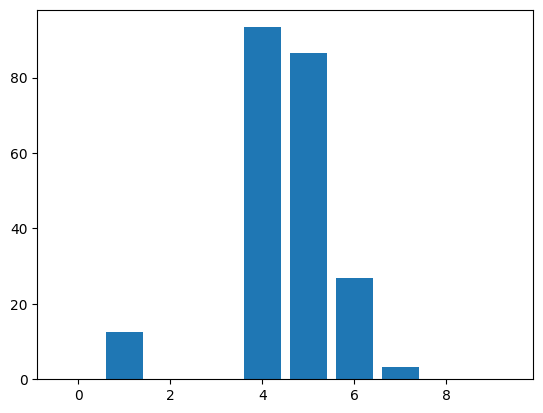

In [ ]:
# Importancia de características para regresión linear
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
#from matplotlib import pyplot

# creamos el conjunto de datos
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# definimos el modelo
model = LinearRegression()

# ajustamos el modelo
model.fit(X, y)

# obtenemos la importancia
importance = model.coef_

# resume la importancia de las características
for i,v in enumerate(importance):
 print('característica: %0d, Score/puntuación: %.5f' % (i,v))

# hace una gráfica de la importancia de las características
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Regresión logística

Podemos hacer lo mismo con la regesión logística

Feature: 0, Score: 0.16320
Feature: 1, Score: -0.64301
Feature: 2, Score: 0.48497
Feature: 3, Score: -0.46190
Feature: 4, Score: 0.18432
Feature: 5, Score: -0.11978
Feature: 6, Score: -0.40602
Feature: 7, Score: 0.03772
Feature: 8, Score: -0.51785
Feature: 9, Score: 0.26540


<BarContainer object of 10 artists>

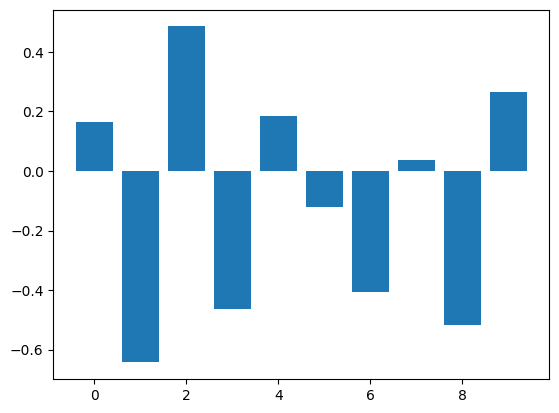

In [ ]:
# Importancia de características para regresión logística
from sklearn.linear_model import LogisticRegression

# creamos el conjunto de datos de clasificación

# definimos el conjunto de datos
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# definimos el modelo
model = LogisticRegression()

# ajustamos el modelo
model.fit(X, y)

# guardamos la importancia
importance = model.coef_[0]

# resumimos los resultados
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

Recuerda que este es un problema de clasificación con clases 0 y 1. Observa que los coeficientes son tanto positivos como negativos. Las puntuaciones positivas indican una característica que predice la clase 1, mientras que las puntuaciones negativas indican una característica que predice la clase 0.

No se puede identificar claramente un patrón de características importantes y no importantes a partir de estos resultados.

## Importancia de las características basada en la permutación de características

La importancia de características por permutación es una técnica para calcular puntuaciones de importancia relativa que es **independiente del modelo utilizado**.

Primero, se ajusta un modelo en el conjunto de datos. Luego, el modelo se utiliza para hacer predicciones en un conjunto de datos, pero los valores de una característica (columna) en el conjunto de datos se mezclan. Esto se repite para cada característica en el conjunto de datos. Luego, todo este proceso se repite 3, 5, 10 o más veces. El resultado es una puntuación de importancia media para cada característica de entrada (y distribución de puntuaciones dadas las repeticiones).

Este enfoque se puede utilizar para regresión o clasificación y requiere que se elija una métrica de rendimiento como base del _score_ de importancia, como el error cuadrado medio para regresión y la precisión para clasificación.

La selección de características por permutación se puede utilizar a través de la función `permutation_importance()`, que toma un modelo ajustado, un conjunto de datos (el conjunto de entrenamiento o prueba está bien) y una función de _score_.

A demás de ser más general, la importancia de características basada en la permutación supera las limitaciones de la importancia de características basada en la impureza: no tienen sesgo hacia características de alta cardinalidad (valores que se repiten mucho).

El cálculo para la importancia completa por permutación es más costoso. Las características se permutan _n_ veces y el modelo se reajusta para estimar su importancia.

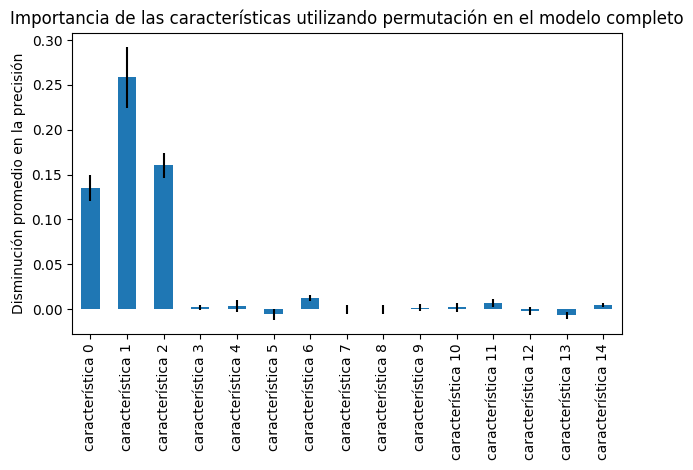

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Importancia de las características utilizando permutación en el modelo completo")
ax.set_ylabel("Disminución promedio en la precisión")
fig.tight_layout()
plt.show()

Se detectan las mismas características como las más importantes utilizando ambos métodos. Aunque las importancias relativas varían. Como se observa en los gráficos, la importancia basada en la disminución de impureza (MDI) es menos probable que omita por completo una característica en comparación con la importancia por permutación.

## * Selección de características basada en la importancia

Los _scores_ de importancia de características se pueden usar para ayudar a interpretar los datos, pero también se pueden usar directamente para ayudar a clasificar y seleccionar características que sean más útiles para un modelo predictivo.

Podemos demostrar esto con un pequeño ejemplo.

Recordar que nuestro conjunto de datos sintético tiene 1000 ejemplos, cada uno con 10 variables de entrada, de las cuales cinco son redundantes y cinco son importantes para el resultado. Podemos usar las puntuaciones de importancia de características para ayudar a seleccionar las cinco variables relevantes y usar solo ellas como entradas para un modelo predictivo.

Primero, podemos dividir el conjunto de datos de entrenamiento en conjuntos de entrenamiento y prueba, y entrenar un modelo en el conjunto de entrenamiento, hacer predicciones en el conjunto de prueba y evaluar el resultado utilizando la precisión de clasificación. Utilizaremos un modelo de regresión logística como modelo predictivo.

Esto nos dará una base para la comparación cuando eliminamos algunas características utilizando las puntuaciones de importancia de características.

Primero evaluamos un modelo de regresión logística utilizando todas las características como entrada en nuestro conjunto de datos sintético:

In [ ]:
# evaluación del modelo usando todas las características
from sklearn.metrics import accuracy_score

# Generamos nuvamente el conjunto de datos
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# Separamos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Ajustamos el modelo
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# lo evaluamos
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 84.55


Dado que creamos el conjunto de datos, esperaríamos obtener resultados semejantes con la mitad de las variables de entrada.

Podemos utilizar cualquiera de las puntuaciones de importancia de características exploradas anteriormente, pero en este caso utilizaremos las puntuaciones de importancia de características proporcionadas por el **bosque aleatorio** (random forest).

Podemos utilizar la clase `SelectFromModel` para definir tanto el modelo del que deseamos calcular las puntuaciones de importancia, en este caso `RandomForestClassifier`, como la cantidad de características a seleccionar, que en este caso es 5.

In [ ]:
# Evaluación de un modelo utilizando 5 características elegidas con la importancia del bosque aleatorio

from sklearn.feature_selection import SelectFromModel

# Función para la selección de las características usando Bosques Aleatórios
def select_features(X_train, y_train, X_test):
 # configuramos para selecciona un subconjunto de características
 fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=5)
 # Fiteamos los datos
 fs.fit(X_train, y_train)
 # Ahora transformamos los datos de entrenamiento
 X_train_fs = fs.transform(X_train)
 # Transformamos los datos de testeo
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

# Generamos los datos
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

# Separar entre entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Selección de las características
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Ajustamos el modelo con regresión logística
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)

# Evaluamos el modelo
yhat = model.predict(X_test_fs)

# Evaluamos las predicciones
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 84.55


Sorpreendentemente (o no), obtenemos el mismo resultado usando solo 5 características del modelo, en vez de las 10!

Lo interesante es que las características relevantes han sido seleccionadas de forma completamente auotmática.

# Balance Cesgo - Varianza | _bias-variance trade-off_

Cesgo y varianza: distintas características de error:


Cuando discutimos la predicción de modelos, es importante entender los errores de predicción (sesgo y varianza). Existe un compromiso entre la capacidad de un modelo para minimizar el sesgo y la varianza. Comprender adecuadamente estos errores nos ayudaría no solo a construir modelos precisos, sino también a evitar el error de sobreajuste y subajuste.

¿Qué son esos tipos de errores?

El **sesgo** es la diferencia entre la predicción promedio de nuestro modelo y el valor correcto que estamos tratando de predecir. Un modelo con alto sesgo presta muy poca atención a los datos de entrenamiento y simplifica demasiado el modelo. Esto siempre conduce a un alto error en los datos de entrenamiento y prueba.

La **varianza** es la variabilidad de la predicción del modelo para un punto de datos dado o un valor que nos dice la dispersión de nuestros datos. Un modelo con alta varianza presta mucha atención a los datos de entrenamiento y no generaliza en los datos que no ha visto antes. Como resultado, estos modelos funcionan muy bien en los datos de entrenamiento, pero tienen altas tasas de error en los datos de prueba.

#### **Un poco (bastante) de matemática**: Decomposición cesgo-varianza del error cuadrático promedio (MSE)

Digamos que la variable que estamos tratando de predecir es _Y_ y otras covariables son _X_. Asumimos que hay una relación entre los dos, de tal manera que

_Y = f(X) + e_

Donde _e_ es el término de error y se distribuye normalmente con una media de 0.

Haremos un modelo _f^(X)_ de _f(X)_ usando regresión lineal o cualquier otra técnica de modelado.

Entonces, el error cuadrado esperado en un punto x es

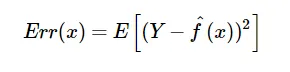

El Err(x) se puede descomponer aún más como

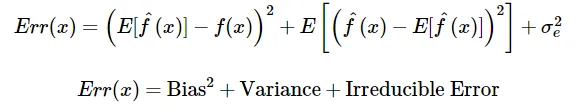

Err(x) es la suma del sesgo al cuadrado, la varianza y el error irreducible.

El error irreducible es el error que no puede reducirse mediante la creación de buenos modelos. Es una medida de la cantidad de ruido en nuestros datos. Aquí es importante entender que, sin importar cuán bueno hagamos nuestro modelo, nuestros datos tendrán cierta cantidad de ruido o error irreducible que no se puede eliminar.

Analisemos visualmente de forma más intuitiva los coceptos de cezgo y varianza

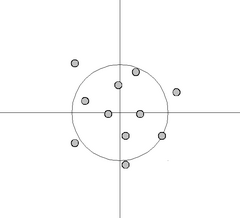

Cesgo pequeño, varianza grande

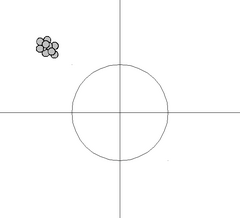

Cesgo grande, varianza pequeña

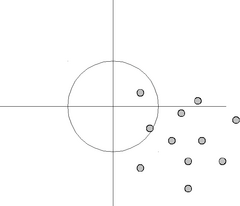

Cesgo y varianza grandes

Eso les hace acordar a alguna situación que ya vimos en este curso?

## Repaso: ejercício 2, semana 6, módulo 2

Creamos un conjunto de datos fictício y separemos en conjuntos de entrenamiento y uno de prueba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


N_SAMPLES = 20 # cuantos datos vamos a generar (cuantos pares {t,x}, líneas de una base de datos, etc.)
x = np.linspace(0,1,num=N_SAMPLES).reshape(-1,1)

# Fijamos la semilla aleatoria, por si queremos reproducir exactamente los mismos resultados en otro momento
np.random.seed(42)

# Generamos puntos a partir de ella
def ground_truth(x):
    return 4 * x + 2 * np.sin(x*6)

# Agregamos ruido a los datos
t = ground_truth(x) + 0.5*np.random.randn(N_SAMPLES,1)

# Separamos en entrenamiento y prueba
x_train, x_test, t_train, t_test = train_test_split(x, t, random_state=42)

Conviene siempre visualuzar los datos para certificarse que esté todo bien:


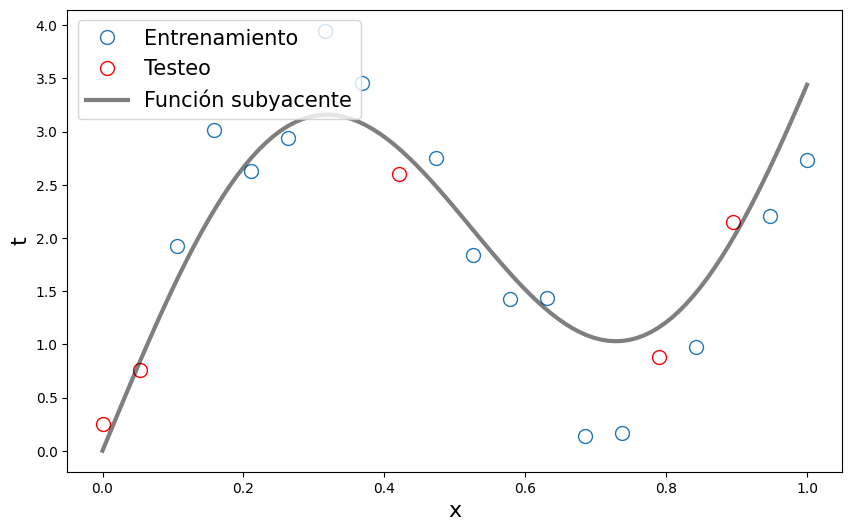

In [2]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

x_ = np.linspace(0,1, 100).reshape(-1,1)
ax.plot(x_train, t_train, 'o', ms=10, mfc='None', label='Entrenamiento')
ax.plot(x_test, t_test, 'or', ms=10, mfc='None', label='Testeo')
ax.plot(x_, ground_truth(x_), 'k-', lw=3, alpha=0.5, label='Función subyacente')
ax.legend(loc=2, fontsize=15)

plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.show()

## Usemos el método de regularización de ridge

Creamos la función ridge que genera un objeto Pipeline implementando la regresión de ridge.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def ridge(m, lam):
    """
    Construye un pipeline para la regresión contraída

    :param int m: grado del polinomio de las características
    :param float ll: coeficiente de regularización lambda

    atención: la función ridge toma como argumento alpha = lambda/2
    """
    return Pipeline([('poly_features', PolynomialFeatures(degree=m)),
                     ('regressor', Ridge(alpha=lam/2.0,fit_intercept=False))])

## Haga un bucle sobre los valores de grado y lambda y evalúe el modelo utilizando el conjunto de pruebas.

Primero haremos um bucle en M, también de 1 a 9 y veamos como queda el error cuadrático medio (MSE) en función de $M$. Por ahora fijaremos $\lambda = 0.01$.

Después haremos un bucle en $\lambda$ con $M$ fijo. Y finalmente haremos un bucle doble y una gráfica 2D para elejir la mejor combinación de los dos hiperparámetros.

In [24]:
from sklearn.metrics import mean_squared_error

# Crea una lista de grados (de los polinomios)
degrees = range(1, 10)
lam = 0.01

# inicializa listas
train_errors = []
test_errors = []
models = []

# itera sobre todos los grados
for M in degrees:
    #print(f"Grado del polinomio: {M}")

    # Crea el modelo polinomial
    pr = ridge(M, lam)

    # Hace el fit
    pr.fit(x_train, t_train)

    # Evalua los errores
    # (no usaremos más la función compute_errors definda en clase, para que no nos imprima todos lo MSE en la pantalla)
    train_e = mean_squared_error(t_train, pr.predict(x_train))
    test_e  = mean_squared_error(t_test, pr.predict(x_test))

    # Graba los resultados en listas
    train_errors.append(train_e)
    test_errors.append(test_e)
    models.append(pr)

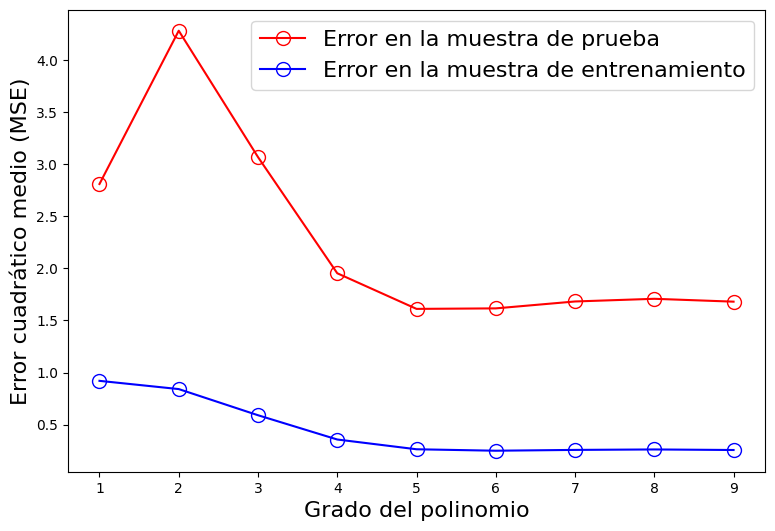

In [25]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

ax.plot(range(1, len(test_errors)+1), test_errors, '-or', mfc='None', ms=10, label='Error en la muestra de prueba')
ax.plot(range(1, len(train_errors)+1), train_errors, '-ob', mfc='None', ms=10, label='Error en la muestra de entrenamiento')
_ = ax.legend(loc=0, fontsize=16)
_ = ax.set_xlabel('Grado del polinomio', size=16)
_ = ax.set_ylabel('Error cuadrático medio (MSE)', size=16)

Vean que, como esperado, ¡no tenemos más overfitting! Con eso el MSE en el conjunto de entrenamiento también para de disminuir. Igual parece que conviene ir hasta M = 9 para tener el menor MSE en los dos conjuntos.

Pero ¿no dependerá de $\lambda$ ese resultado?

Miremos ahora que pasa con vários valores de $\lambda$ distribuídos logarítmicamente, fijando arbitráriamente a M en 5:

In [28]:
# conjunto de valores de lambda (espaciados de forma logarítmica entre 10^-7 y 1)
lls = np.logspace(-7, -1, 20)

# Fijamos M
M = 5

# inicializa listas
train_errors = []
test_errors = []
models = []

# Itera sobre los valores de lambda
for ll in lls:
    #print(f"Valor de Lambda: {ll}")

    # Crea el modelo polinomial
    pr = ridge(M, ll)

    # Hace el fit
    pr.fit(x_train, t_train)

    # Evalua los errores
    train_e = mean_squared_error(t_train, pr.predict(x_train))
    test_e  = mean_squared_error(t_test, pr.predict(x_test))

    # Graba los resultados en listas
    train_errors.append(train_e)
    test_errors.append(test_e)
    models.append(pr)

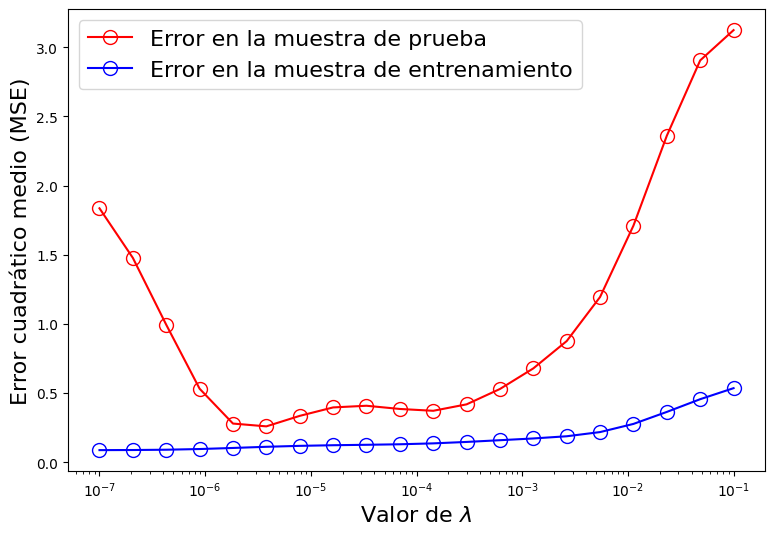

In [29]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

ax.semilogx(lls, test_errors, '-or', mfc='None', ms=10, label='Error en la muestra de prueba')
ax.semilogx(lls, train_errors, '-ob', mfc='None', ms=10, label='Error en la muestra de entrenamiento')

_ = ax.legend(loc=0, fontsize=16)
_ = ax.set_xlabel('Valor de $\lambda$', size=16)
_ = ax.set_ylabel('Error cuadrático medio (MSE)', size=16)

Vean que, cuanto menor el valor de $\lambda$, menos regularización. Para $\lambda ≲ 3 \times 10^{-6}$, tenemos claramente un sobre-ajuste. O sea, la regularización no es suficiente para evitar el _overfitting_. Para valores más grandes de $\lambda$ la calidad del MSE pasa a disminuir. O sea, el témino de la norma L2 en la función error pasa a tener un peso más grande y no conviene tanto disminuir el MSE en relación a la norma del vector de pesos.

¡Eso es la dicotomía sesgo-varianza! Evitar el overfit es disminuir la varianza en los pesos. O sea, los pesos quedan mejor determinados con la regularización. Los pesos ya no tienen enormes variaciones con pequeños cambios del _dataset_. Por otro lado, la regularización termina induciendo un cesgo, o sea, empeorando la calidad del fita, lleavando a un MSE mayor.

En la gráfica de arriba, queda bien claro que hay un valor de $\lambda$ óptimo, para el cual tenemos el menor cesgo (menos MSE), sin que haya overfit. Ese valor es $\lambda \simeq 3 \times 10^{-6}$. O sea, se obtiene un balance sesgo-varianza ideal.

Pero todo eso fue con un valor fijo del grado del polinómio M. Ahora optimizemos simultaneamente los dos hiperparámetros.

Lo que nos interesa es saber los valores de M y $\lambda$ que corresponden al **menor valor del MSE en el conjunto de testeo**. Pare eso, en el ejercício, hicimos un bucle simultaneamente en $\lambda$ y en M, etc. Después aprendimos como hacer esso con _grid search cross validation_ etc.

Ahora intentemos entender el comportamiento, a ver qué tiene que ver con el cesgo y la varianza.

In [31]:
# Vamos a generar várias muestras

N_SAMPLES = 15
x = np.linspace(0,1,num=N_SAMPLES).reshape(-1,1)

def ground_truth(x):
    return 4 * x+ np.sin(x*6)

N_REPEAT = 50

all_data = np.empty([N_REPEAT, N_SAMPLES])

# Repeat realization of data many times
for i in range(N_REPEAT):
    t =  ground_truth(x.flatten()) + 0.5*np.random.randn(N_SAMPLES)
#     x_train, x_test, t_train, t_test = train_test_split(x, t)

    all_data[i] = t

In [32]:
x_ = np.linspace(0, 1, 100).reshape(-1, 1)
lls = [0.0, 1e-3, 10.0]

all_predictions = np.empty([len(lls), N_REPEAT, len(x_)])
for i, data in enumerate(all_data):
    for j, ll in enumerate(lls):
        reg = ridge(9, ll)
        reg.fit(x, data)
        all_predictions[j, i] = reg.predict(x_)

In [33]:
print(all_predictions.shape)

(3, 50, 100)


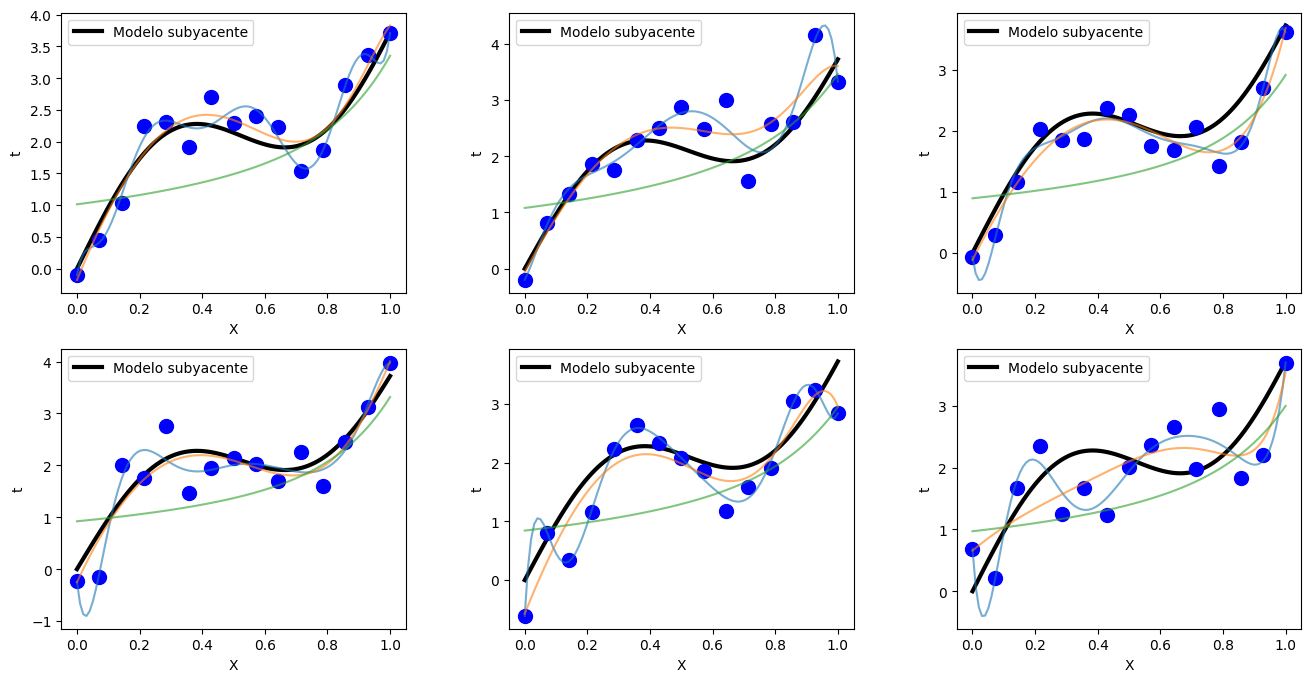

In [36]:
n_columns = 3
N_ROWS = 2

fig = plt.figure(figsize=(16, 4 * N_ROWS))
axs = fig.subplots(ncols=n_columns, nrows=N_ROWS, gridspec_kw={'wspace': 0.3})

# aleatoriamente simulaciones para graficar
ind = np.arange(all_predictions.shape[1])
np.random.shuffle(ind)

for i, ax in enumerate(axs.flatten()):
    # Plot ground truth
    ax.plot(x_, ground_truth(x_), color='k', lw=3, label='Modelo subyacente')

    # Plot data
    ax.plot(x, all_data[ind[i]], 'ob', mfc=None, ms=10)

    ax.legend(loc=0)

    for j in range(len(lls)):
        ax.plot(x_, all_predictions[j, ind[i]], alpha=0.6,
                label='$\lambda = {:.1e}$'.format(lls[j]))


    #Label
    ax.set_xlabel('X')
    ax.set_ylabel('t')

¿Qué se observa de la figura?

* Valores chicos de $\lambda$ (celeste): poco cesgo, mucha varianza
* Valores grandes de $\lambda$ (verde): mucho cesgo, poca varianza
* Valores intermediarios de $\lambda$ (naranja): poco cesgo, poca varianza

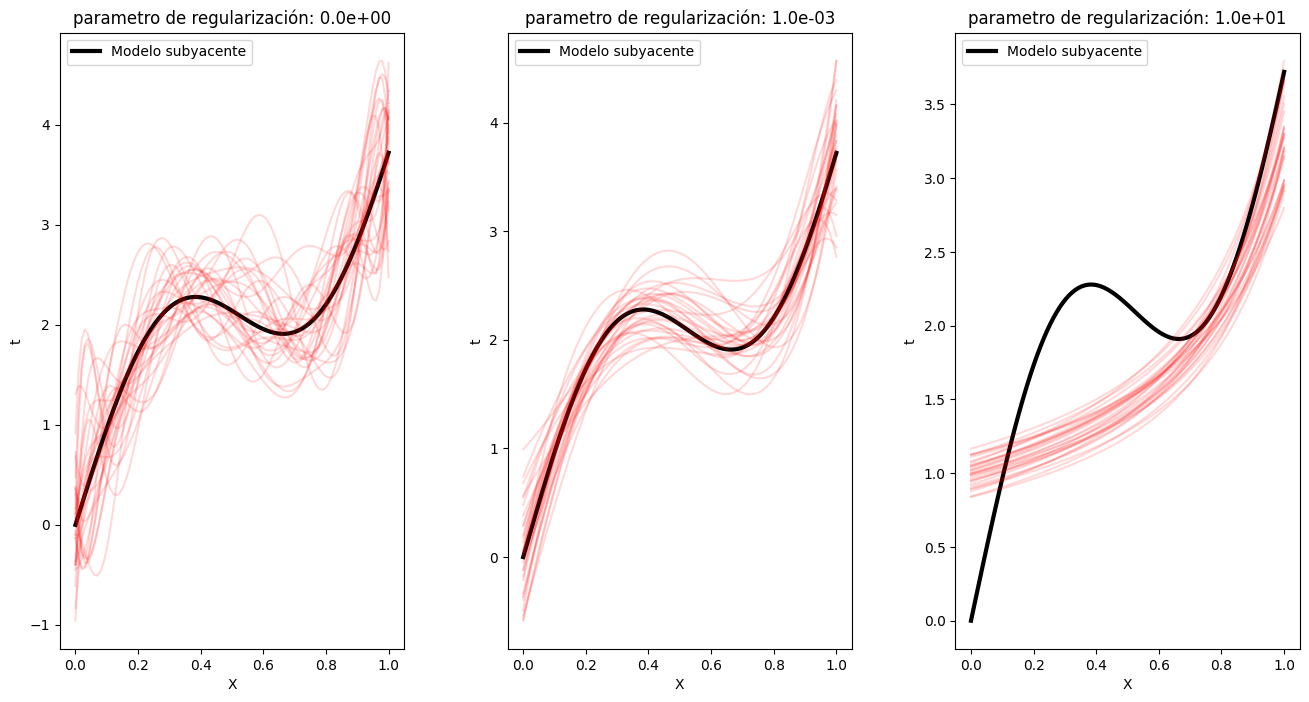

In [38]:
# Mirándolo de otra forma

N_PLOT = 30

fig = plt.figure(figsize=(16, 8))
axs = fig.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.3})

# randomly choose simulations to draw
ind = np.arange(all_predictions.shape[1])
np.random.shuffle(ind)

for i, ax in enumerate(axs):
    ax.plot(x_, ground_truth(x_), color='k', lw=3, label='Modelo subyacente')
    ax.plot(x_, all_predictions[i, ind[:N_PLOT]].T, color='Red', alpha=0.15)
    ax.legend(loc=0)

    #Label
    ax.set_xlabel('X')
    ax.set_ylabel('t')

    # Title
    axs[i].set_title('parametro de regularización: {:.1e}'.format(lls[i]))

## Cálculo completo de sesgo y varianza

In [39]:
# Repetimos para una grilla más fina de lambdas
lls = np.logspace(-5, np.log10(5), 40)
lls = np.concatenate([np.array([0,]), lls])

all_predictions_full = np.empty([len(lls), N_REPEAT, len(x_)])
for i, data in enumerate(all_data):
    for j, ll in enumerate(lls):
        reg = ridge(9, ll)
        reg.fit(x, data)
        all_predictions_full[j, i] = reg.predict(x_)

# All predictions tiene forma n_lambdas x n_repeats x len(x_)

In [40]:
all_predictions_full.shape

(41, 50, 100)

In [43]:
# Error agregado a las medidas
irreduc_err = 0.1

# Predicción promedio sobre las realizaciones de los datos
Ed_y = np.average(all_predictions_full, axis=1)

# Calcula el cesgo (diferencia entra la previsión promedio y el valor real)
bias2 = (Ed_y - ground_truth(x_.flatten()))**2

# Varianza
var = np.mean((Ed_y[:, np.newaxis, :] - all_predictions_full)**2, axis=1)

# Error total
err = bias2 + var + irreduc_err**2

In [44]:
print(var.shape, bias2.shape, err.shape, lls.shape)

(41, 100) (41, 100) (41, 100) (41,)


Text(0, 0.5, 'Error')

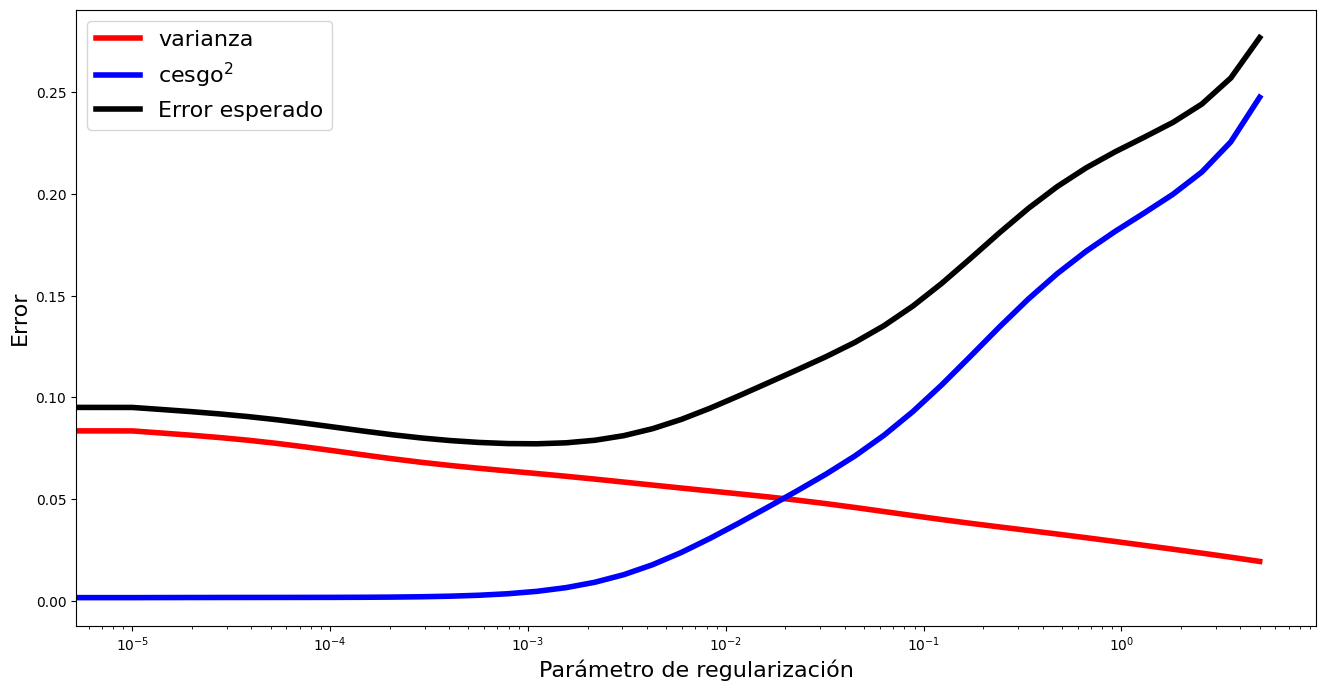

In [47]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
# Plot in same plot, averaged over X
ax.semilogx(lls, var.mean(axis=1), color='r', label='varianza', lw=4)
ax.semilogx(lls, bias2.mean(axis=1), color='b', label='cesgo$^2$', lw=4)
ax.semilogx(lls, err.mean(axis=1), label='Error esperado', lw=4, color='k')

# Title and labels
ax.legend(fontsize=16)
ax.set_xlabel('Parámetro de regularización', size=16)
ax.set_ylabel('Error', size=16)

# ax.invert_xaxis()

Al final, siempre queremos reduzir el MSE.

¿Ahora se entiende mejor de donde viene la optimización para elejir los mejores hiperparámetros?

Lo mismo se hace para la mayor parte de los métodos de aprendizaje automático...